# Compare Attack Success Rate for Different Leakage Models

In the previous notebook, we looked at a singe attack. Here for a proper comparison we launch multiple attacks and look at attack success rate.

Here, we will see that even for a simple target:
1. leakage models obtained with profiling lead to more effective attacks than the standard Hamming weight assumption
2. for building lekage model that is sufficiently precise for the attack, linear regression based profiling needs less traces than template based one

The second point is exactly what is explained https://eprint.iacr.org/2013/353.

This notebook needs leakage models built in notebooks 3 and 4 for different amounts of traces. These models are included in the repository.

The code here is not optimal w.r.t. performance, but this was not the goal of this tutorial.

Part of the leakage modeling tutorial, license is GPLv3, see https://www.gnu.org/licenses/gpl-3.0.en.html<br>
Requires traces and data from [pysca toolbox](https://github.com/ikizhvatov/pysca)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Leakage models obtained in notebooks 3 (with linear regression) and 4 (templates). Reminder: every leakage model function here defines how an intermediate value $x$ maps into predicted leakage.

As we wil be comparing leaakge models build with different number of traces, leakage functions here are additionally parametrized comapred to the previous notebook.

In [2]:
### pre-load models built earlier for different amount of traces

# 8-component LR models
coefs30 = np.load('results/lrmodel9_30traces.npy')
coefs40 = np.load('results/lrmodel9_40traces.npy')
coefs50 = np.load('results/lrmodel9_50traces.npy')
coefs500 = np.load('results/lrmodel9_500traces.npy')
coefs1000 = np.load('results/lrmodel9_1000traces.npy')
coefs2000 = np.load('results/lrmodel9_2000traces.npy')

# reduced templates
means500 = np.load('results/means500.npy') 
means1000 = np.load('results/means1000.npy') 
means2000 = np.load('results/means2000.npy')

### leakage functions 

# 8-component leakage function; beta is a 9-element array (including the intercept)
def leakageModel_LR9(x, coefs):
    result = coefs[8]
    for i in range(0, 8):
        bit = (x >> i) & 1  # this is the definition: gi = [bit i of x]
        result += coefs[i] * bit
    return result

# templates (reduced, i.e. just the mean, because correlation distinguisher does not use variance)
def leakageModel_T(x, means):
    return means[x]

# Hamming weight leakage model
byteHammingWeight = np.load('../data/bytehammingweight.npy') # just a pre-computed HW table
def leakageModel_HW(x):
    return byteHammingWeight[x]

Load attack prerequisites and traces. We read out the traces starting from trace 1000, as traces below that were used to build the models. (There still will be some overlap, but it is not significant for this demonstration.)

In [3]:
inputRange = range(1000, 2000) # get the second part of traces to be independent from model building
SboxNum = 0        # should be the same as for building the leakage models
SampleNum = 1025   # should be the same as for building the leakage models

# load samples and data
npzfile = np.load('../traces/swaes_atmega_power.npz')
data = npzfile['data'][inputRange,SboxNum]
traces = npzfile['traces'][inputRange,SampleNum]

# known key, such that we can highlight the corresponding correlation trace
key = b'\x2b\x7e\x15\x16\x28\xae\xd2\xa6\xab\xf7\x15\x88\x09\xcf\x4f\x3c'
knownKeyByte = np.uint8(key[SboxNum])

# load AES S-Box
sbox = np.load('../data/aessbox.npy')

Pre-compute target variables for all key byte candidates and input byte values. Leakage models will be applied later on.

In [4]:
# compute intermediate variable hypotheses for all the key candidates
k = np.arange(0,256, dtype='uint8')
H = np.zeros((256, len(data)), dtype='uint8')
for i in range(256):
    H[i,:] = sbox[data ^ k[i]]

Obtain success rate by running many experiments.

Each experiment is an attack with increasing number of traces, exactly as in the previous notebook.

Success rate (to be precise, first-order success rate) is defined as the ratio of attacks where the correct key cadidate is ranked first.

First, we define parameters specific to this step.

In [5]:
NumExperiments = 20                   # number of experiments to run
MaxTraceNum = 50                      # maximum number of traces in a single experiment 
TraceNumbers = range(10, MaxTraceNum) # trace numbers through which to run

# Ensure that the combination of first two parameters does not overrun the trace array!

Second, here are functions to get success rate.

In [6]:
# Run CPA on a single-sample traces
# Correlate each line of HL with the observed leakage for every key candidate
# Returns an array of 256 correlation coefficients
def cpa(HL, traces, startTrace, numTraces):
    endTrace = startTrace + numTraces
    c = np.zeros(256)
    for i in range(256):
        c[i] = np.corrcoef(traces[startTrace:endTrace], HL[i][startTrace:endTrace])[0,1]
    return c

# Get success rate of CPA with a given leakage model
# Repeats CPA many times on different part of the traceset. Each CPA is in turn for increasing number of traces.
# Returns the success rate for incrasing number of traces.
def getSuccessRate(HL):

    SuccessMatrix = np.zeros((NumExperiments, len(TraceNumbers)))

    for s in range(NumExperiments):
        startTrace = MaxTraceNum * s
        for n in range(len(TraceNumbers)):
            # run CPA
            c = cpa(HL, traces, startTrace, TraceNumbers[n])
            # find position of the correct candidate in the sorted list
            SuccessMatrix[s, n] = len(np.where(c > c[knownKeyByte])[0])

    # compute success rate
    SuccessRate = np.zeros(len(TraceNumbers))
    for i in range(len(TraceNumbers)):
        Ranking = SuccessMatrix[:, i]
        SuccessRate[i] = len(np.where(Ranking == 0)[0]) / np.float(NumExperiments)

    return SuccessRate

Now we obtain success rate of CPA with different leakage models.

Takes some time to run.

In [7]:
# apply different leakage functions to the target variable to get leakage predictions
HL_HW = [leakageModel_HW(x) for x in H]
HL_LR2000 = [leakageModel_LR9(x, coefs2000) for x in H]
HL_T2000 = [leakageModel_T(x, means2000) for x in H]

# run experiments with different leakge predictions to get success rate
SuccessRateHW = getSuccessRate(HL_HW)
SuccessRateLR2000 = getSuccessRate(HL_LR2000)
SuccessRateT2000 = getSuccessRate(HL_T2000)

Visualize success rate curves.

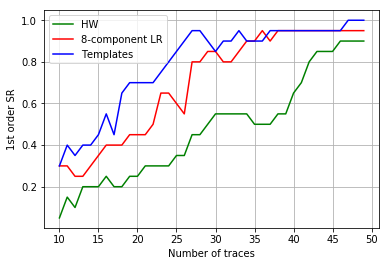

In [8]:
plt.plot(TraceNumbers, SuccessRateHW, color='green')
plt.plot(TraceNumbers, SuccessRateLR2000, color='red')
plt.plot(TraceNumbers, SuccessRateT2000, color='blue')
plt.xlabel('Number of traces')
plt.ylabel('1st order SR')
plt.legend(['HW', '8-component LR', 'Templates'], loc='best')
plt.grid()
plt.show()

As expected, leakage model obtained with templates leads to the highest succes rate. Next comes linear regression based leakage model. But this was for the maximum number of traces in profiling.

Now let us see what happens when the number of traces in profiling is smaller.

In [9]:
HL_LR500 = [leakageModel_LR9(x, coefs500) for x in H]
HL_LR1000 = [leakageModel_LR9(x, coefs1000) for x in H]
HL_T500 = [leakageModel_T(x, means500) for x in H]
HL_T1000 = [leakageModel_T(x, means1000) for x in H]

SuccessRateLR500 = getSuccessRate(HL_LR500)
SuccessRateLR1000 = getSuccessRate(HL_LR1000)
SuccessRateT500 = getSuccessRate(HL_T500)
SuccessRateT1000 = getSuccessRate(HL_T1000)

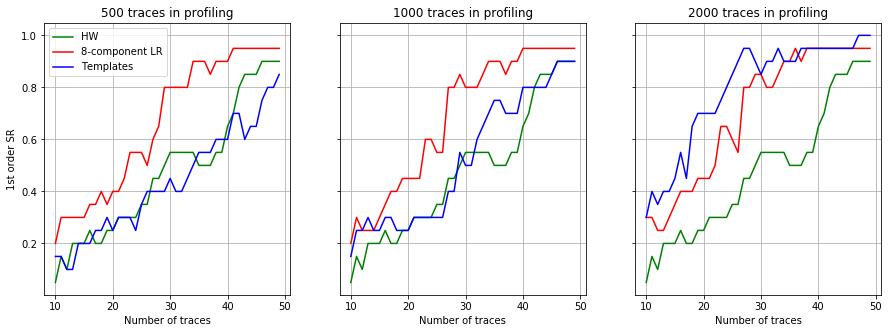

In [10]:
fig, (axA, axB, axC) = plt.subplots(1,3, sharey=True, figsize=(15, 5), squeeze=True)

axA.plot(TraceNumbers, SuccessRateHW, color='green')
axA.plot(TraceNumbers, SuccessRateLR500, color='red')
axA.plot(TraceNumbers, SuccessRateT500, color='blue')

axB.plot(TraceNumbers, SuccessRateHW, color='green')
axB.plot(TraceNumbers, SuccessRateLR1000, color='red')
axB.plot(TraceNumbers, SuccessRateT1000, color='blue')

axC.plot(TraceNumbers, SuccessRateHW, color='green')
axC.plot(TraceNumbers, SuccessRateLR2000, color='red')
axC.plot(TraceNumbers, SuccessRateT2000, color='blue')

axA.set_title('500 traces in profiling')
axB.set_title('1000 traces in profiling')
axC.set_title('2000 traces in profiling')
axA.set_ylabel('1st order SR')
axA.legend(['HW', '8-component LR', 'Templates'], loc='best')
for ax in [axA, axB, axC]:
    ax.set_xlabel('Number of traces')
    ax.grid()
plt.show()

We can see that with less nubmer of traces for profiling, templates are not so good any more! While linear regression is.

This is beacuse the leakge of this target is so simple that we do not need to estimate 256 templates to get a precise enough model. A linear regression model with 9 parameters and simple basis functions is precise enough and needs less traces to be estimated.

Finally, let us run extra experiments to see when linear regression based model "saturates".

In [11]:
HL_LR30 = [leakageModel_LR9(x, coefs30) for x in H]
HL_LR40 = [leakageModel_LR9(x, coefs40) for x in H]
HL_LR50 = [leakageModel_LR9(x, coefs50) for x in H]

SuccessRateLR30 = getSuccessRate(HL_LR30)
SuccessRateLR40 = getSuccessRate(HL_LR40)
SuccessRateLR50 = getSuccessRate(HL_LR50)

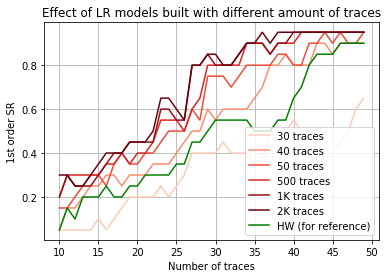

In [12]:
shadesOfRed = plt.get_cmap("Reds")
plt.plot(TraceNumbers, SuccessRateLR30, color=shadesOfRed(50), label='30 traces')
plt.plot(TraceNumbers, SuccessRateLR40, color=shadesOfRed(100), label='40 traces')
plt.plot(TraceNumbers, SuccessRateLR50, color=shadesOfRed(150), label='50 traces')
plt.plot(TraceNumbers, SuccessRateLR500, color=shadesOfRed(180), label='500 traces')
plt.plot(TraceNumbers, SuccessRateLR1000, color=shadesOfRed(230), label='1K traces')
plt.plot(TraceNumbers, SuccessRateLR2000, color=shadesOfRed(255), label='2K traces')
plt.plot(TraceNumbers, SuccessRateHW, color='green', label='HW (for reference)')
plt.xlabel('Number of traces')
plt.ylabel('1st order SR')
plt.title('Effect of LR models built with different amount of traces')
plt.legend(loc='lower right')
plt.grid()
plt.show()

We can see that with just 40 traces, the LR model outperforms Hamming weight. With just 50 traces it "saturates", i.e. further increase of the amount of traces for building the model does not lead to a significant improvement in the attack success rate.
 
 This demonstration completes the tutorial.